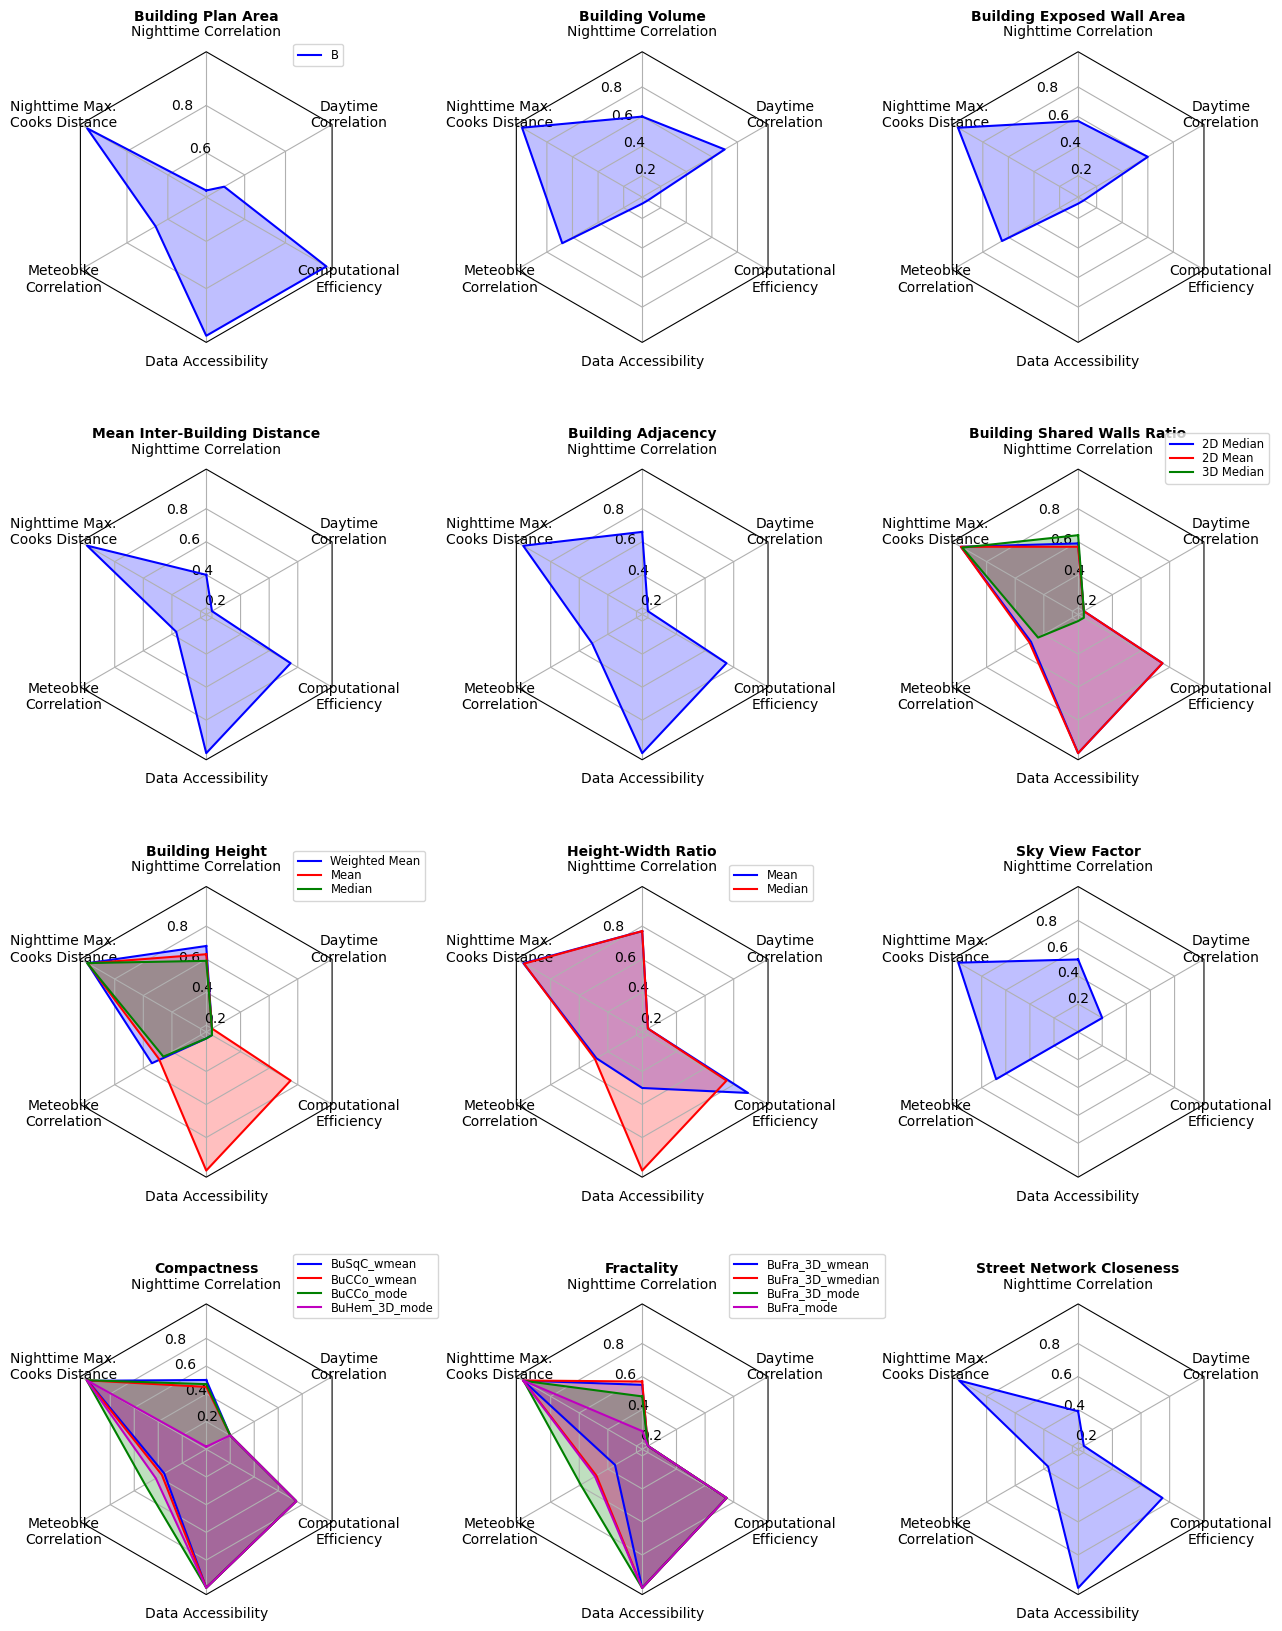

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    data = [
        ['Nighttime Correlation', 'Nighttime Max.\nCooks Distance', 'Meteobike\nCorrelation', 'Data Accessibility', 'Computational\nEfficiency', 'Daytime\nCorrelation'],
        ('Building Plan Area', [
            [0.44, 0.995, 0.66, 1, 1, 0.5]]),
        ('Building Volume', [
            [0.60, 0.994, 0.68, 0.1, 0.1, 0.7]]),
        ('Building Exposed Wall Area', [
            [0.57, 0.994, 0.65, 0.1, 0.1, 0.6]]),
        ('Mean Inter-Building Distance', [
            [0.4, 0.994, 0.37, 1, 0.75, 0.2]]),
        ('Building Adjacency', [
            [0.66, 0.992, 0.51, 1, 0.75, 0.2]]),
        ('Building Shared Walls Ratio', [
            [0.59, 0.98, 0.49, 1, 0.75, 0.2], #2D median
            [0.57, 0.98, 0.50, 1, 0.75, 0.2], #2D mean
            [0.64, 0.97, 0.44, 0.2, 0.2, 0.2]]), #3D median
        ('Building Height', [
            [0.68, 0.991, 0.54, 0.2, 0.2, 0.2], #Weighted mean
            [0.63, 0.989, 0.49, 1, 0.75, 0.2], #Mean
            [0.59, 0.993, 0.46, 0.2, 0.2, 0.2]]), #Median
        ('Height-Width Ratio', [
            [0.77, 0.991, 0.48, 0.5, 0.9, 0.2], #Median
            [0.77, 0.986, 0.49, 1, 0.75, 0.2]]), #Mean
        ('Sky View Factor', [
            [0.52, 0.994, 0.68, 0, 0, 0.2]]),
        ('Compactness', [
            [0.5, 0.988, 0.35, 1, 0.75, 0.2], # BuSqC_wmean
            [0.45, 0.995, 0.37, 1, 0.75, 0.2], # BuCCo_wmean
            [0.47, 0.997, 0.51, 1, 0.75, 0.2], # BuCCo_mode
            [0.019, 0.997, 0.42, 1, 0.75, 0.2]]), # BuHem_3D_mode
        ('Fractality', [
            [0.55, 0.992, 0.35, 1, 0.75, 0.2], # BuFra_3D_wmean
            [0.57, 0.993, 0.48, 1, 0.75, 0.2], # BuFra_3D_wmedian
            [0.48, 0.989, 0.59, 1, 0.75, 0.2], # BuFra_3D_mode
            [0.27, 0.994, 0.49, 1, 0.75, 0.2]]), #BuFra_mode
        ('Street Network Closeness', [
            [0.39, 0.992, 0.37, 1, 0.75, 0.2]]),
    ]
    return data


if __name__ == '__main__':
    N = 6
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(15, 20), nrows=4, ncols=3,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate Axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('BuAre_sum')
    legend = axs[0, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('2D Median','2D Mean','3D Median')
    legend = axs[1, 2].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('Weighted Mean','Mean', 'Median')
    legend = axs[2, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('Mean', 'Median')
    legend = axs[2, 1].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    
    labels = ('BuSqC_wmean','BuCCo_wmean','BuCCo_mode','BuHem_3D_mode')
    legend = axs[3, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('BuFra_3D_wmean','BuFra_3D_wmedian','BuFra_3D_mode','BuFra_mode')
    legend = axs[3, 1].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')

    #increase wspacing
    plt.subplots_adjust(wspace=0.5)

    plt.show()

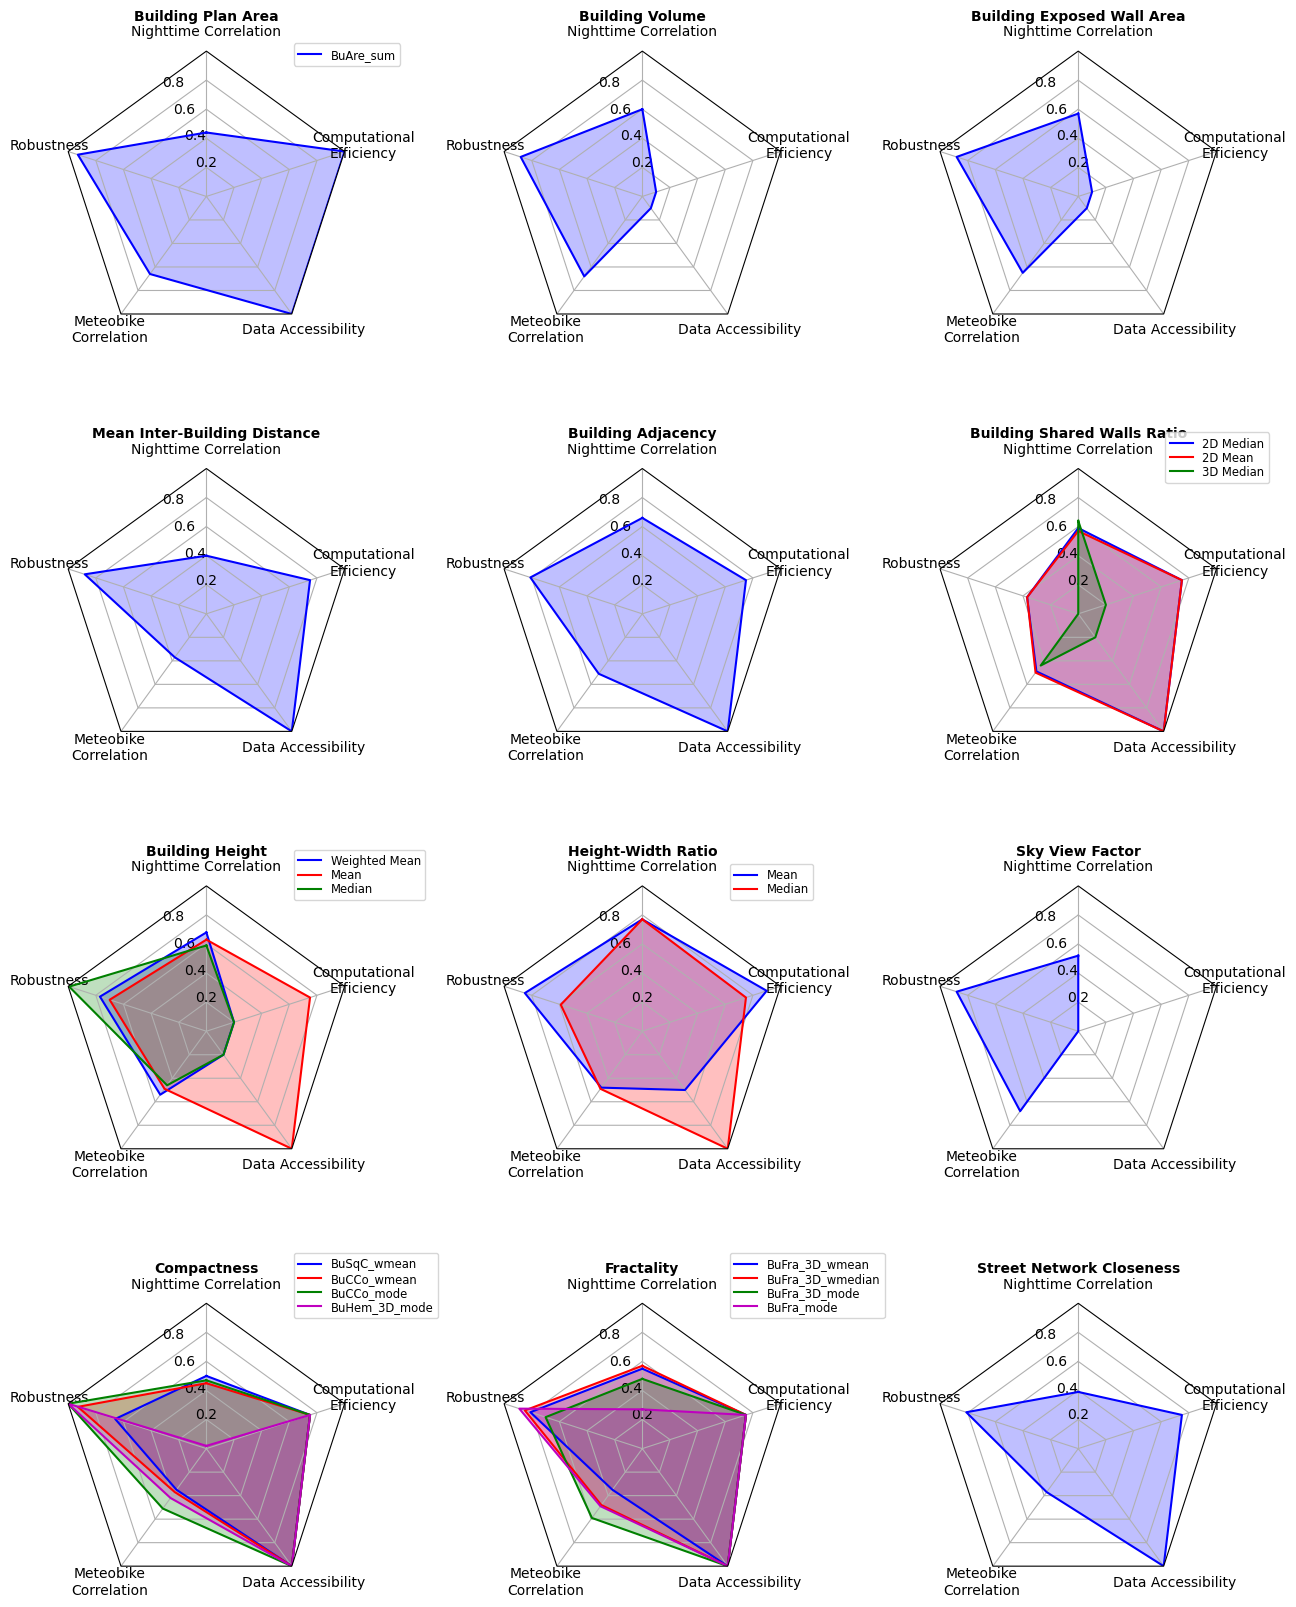

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def real_cooks():
    data = [
        ['Nighttime Correlation', 'Nighttime Max.\nCooks Distance', 'Meteobike\nCorrelation', 'Data Accessibility', 'Computational\nEfficiency'],
        ('Building Plan Area', [
            [0.44, 0.995, 0.66, 1, 1]]),
        ('Building Volume', [
            [0.60, 0.994, 0.68, 0.1, 0.1]]),
        ('Building Exposed Wall Area', [
            [0.57, 0.994, 0.65, 0.1, 0.1]]),
        ('Mean Inter-Building Distance', [
            [0.4, 0.994, 0.37, 1, 0.75]]),
        ('Building Adjacency', [
            [0.66, 0.992, 0.51, 1, 0.75]]),
        ('Building Shared Walls Ratio', [
            [0.59, 0.98, 0.49, 1, 0.75], #2D median
            [0.57, 0.98, 0.50, 1, 0.75], #2D mean
            [0.64, 0.97, 0.44, 0.2, 0.2]]), #3D median
        ('Building Height', [
            [0.68, 0.991, 0.54, 0.2, 0.2], #Weighted mean
            [0.63, 0.989, 0.49, 1, 0.75], #Mean
            [0.59, 0.993, 0.46, 0.2, 0.2]]), #Median
        ('Height-Width Ratio', [
            [0.77, 0.991, 0.48, 0.5, 0.9], #Median
            [0.77, 0.986, 0.49, 1, 0.75]]), #Mean
        ('Sky View Factor', [
            [0.52, 0.994, 0.68, 0, 0]]),
        ('Compactness', [
            [0.5, 0.988, 0.35, 1, 0.75], # BuSqC_wmean
            [0.45, 0.995, 0.37, 1, 0.75], # BuCCo_wmean
            [0.47, 0.997, 0.51, 1, 0.75], # BuCCo_mode
            [0.019, 0.997, 0.42, 1, 0.75]]), # BuHem_3D_mode
        ('Fractality', [
            [0.55, 0.992, 0.35, 1, 0.75], # BuFra_3D_wmean
            [0.57, 0.993, 0.48, 1, 0.75], # BuFra_3D_wmedian
            [0.48, 0.989, 0.59, 1, 0.75], # BuFra_3D_mode
            [0.27, 0.994, 0.49, 1, 0.75]]), #BuFra_mode
        ('Street Network Closeness', [
            [0.39, 0.992, 0.37, 1, 0.75]]),
    ]
    return data

def normalised_cooks():
    ### Normalised Cook's Distance using value-min/max-min
    data = [
        ['Nighttime Correlation', 'Robustness', 'Meteobike\nCorrelation', 'Data Accessibility', 'Computational\nEfficiency'],
        ('Building Plan Area', [
            [0.44, 0.93, 0.66, 1, 1]]),
        ('Building Volume', [
            [0.60, 0.88, 0.68, 0.1, 0.1]]),
        ('Building Exposed Wall Area', [
            [0.57, 0.88, 0.65, 0.1, 0.1]]),
        ('Mean Inter-Building Distance', [
            [0.4, 0.88, 0.37, 1, 0.75]]),
        ('Building Adjacency', [
            [0.66, 0.81, 0.51, 1, 0.75]]),
        ('Building Shared Walls Ratio', [
            [0.59, 0.37, 0.49, 1, 0.75], #2D median
            [0.57, 0.37, 0.50, 1, 0.75], #2D mean
            [0.64, 0.0, 0.44, 0.2, 0.2]]), #3D median
        ('Building Height', [
            [0.68, 0.77, 0.54, 0.2, 0.2], #Weighted mean
            [0.63, 0.70, 0.49, 1, 0.75], #Mean
            [0.59, 0.993, 0.46, 0.2, 0.2]]), #Median
        ('Height-Width Ratio', [
            [0.77, 0.85, 0.48, 0.5, 0.9], #Median
            [0.77, 0.59, 0.49, 1, 0.75]]), #Mean
        ('Sky View Factor', [
            [0.52, 0.88, 0.68, 0, 0]]),
        ('Compactness', [
            [0.5, 0.66, 0.35, 1, 0.75], # BuSqC_wmean
            [0.45, 0.93, 0.37, 1, 0.75], # BuCCo_wmean
            [0.47, 1, 0.51, 1, 0.75], # BuCCo_mode
            [0.019, 1, 0.42, 1, 0.75]]), # BuHem_3D_mode
        ('Fractality', [
            [0.55, 0.81, 0.35, 1, 0.75], # BuFra_3D_wmean
            [0.57, 0.85, 0.48, 1, 0.75], # BuFra_3D_wmedian
            [0.48, 0.70, 0.59, 1, 0.75], # BuFra_3D_mode
            [0.27, 0.89, 0.49, 1, 0.75]]), #BuFra_mode
        ('Street Network Closeness', [
            [0.39, 0.81, 0.37, 1, 0.75]]),
    ]
    return data


if __name__ == '__main__':
    N = 5
    theta = radar_factory(N, frame='polygon')

    data = normalised_cooks()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(15, 20), nrows=4, ncols=3,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate Axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_ylim(0, 1)
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('BuAre_sum',)
    legend = axs[0, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('2D Median','2D Mean','3D Median')
    legend = axs[1, 2].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('Weighted Mean','Mean', 'Median')
    legend = axs[2, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('Mean', 'Median')
    legend = axs[2, 1].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    
    labels = ('BuSqC_wmean','BuCCo_wmean','BuCCo_mode','BuHem_3D_mode')
    legend = axs[3, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('BuFra_3D_wmean','BuFra_3D_wmedian','BuFra_3D_mode','BuFra_mode')
    legend = axs[3, 1].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')

    #increase wspacing
    plt.subplots_adjust(wspace=0.5)
    plt.savefig('/Users/lisawink/Documents/paper1/figures/radar_plot.png')
    plt.show()

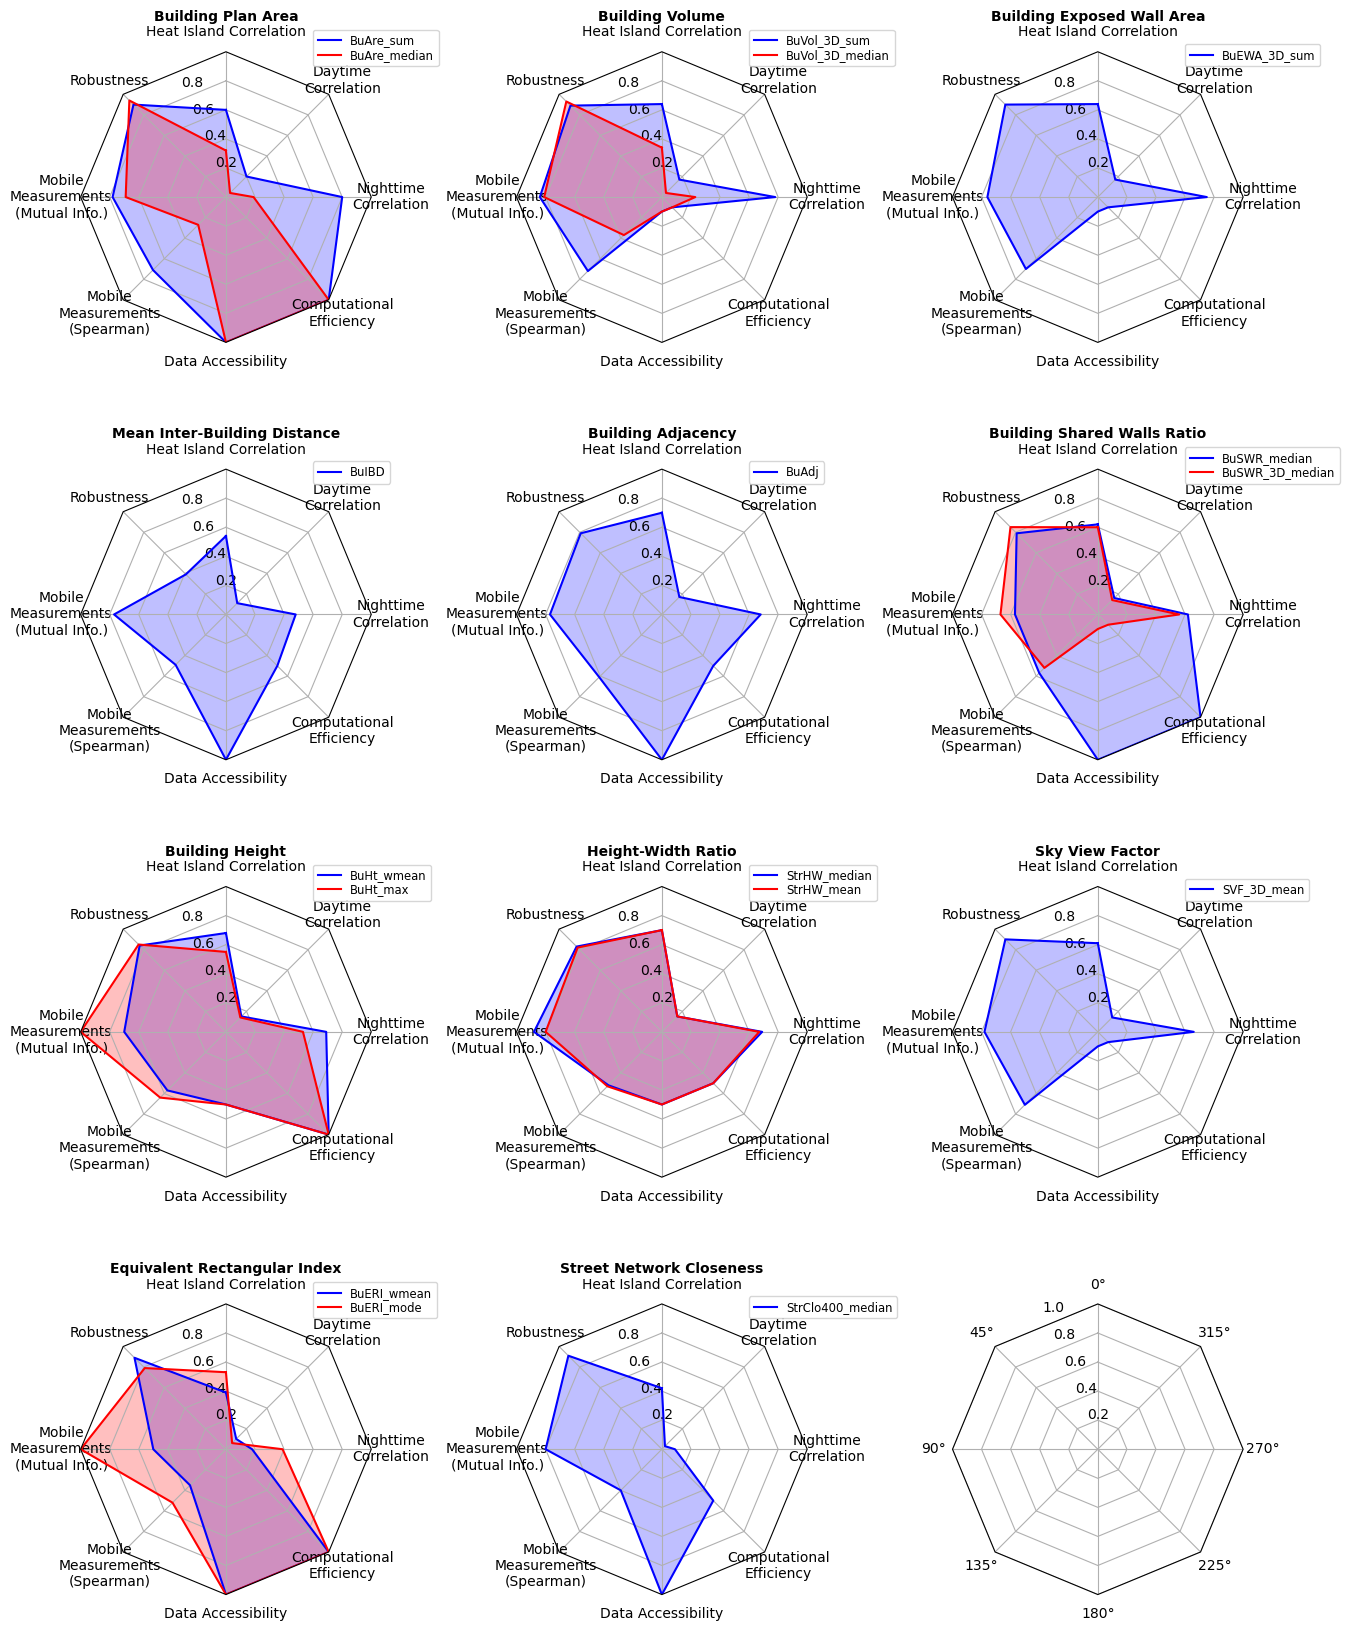

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def real_cooks():
    data = [
        ['Nighttime Correlation', 'Nighttime Max.\nCooks Distance', 'Meteobike\nCorrelation', 'Data Accessibility', 'Computational\nEfficiency'],
        ('Building Plan Area', [
            [0.44, 0.995, 0.66, 1, 1]]),
        ('Building Volume', [
            [0.60, 0.994, 0.68, 0.1, 0.1]]),
        ('Building Exposed Wall Area', [
            [0.57, 0.994, 0.65, 0.1, 0.1]]),
        ('Mean Inter-Building Distance', [
            [0.4, 0.994, 0.37, 1, 0.75]]),
        ('Building Adjacency', [
            [0.66, 0.992, 0.51, 1, 0.75]]),
        ('Building Shared Walls Ratio', [
            [0.59, 0.98, 0.49, 1, 0.75], #2D median
            [0.57, 0.98, 0.50, 1, 0.75], #2D mean
            [0.64, 0.97, 0.44, 0.2, 0.2]]), #3D median
        ('Building Height', [
            [0.68, 0.991, 0.54, 0.2, 0.2], #Weighted mean
            [0.63, 0.989, 0.49, 1, 0.75], #Mean
            [0.59, 0.993, 0.46, 0.2, 0.2]]), #Median
        ('Height-Width Ratio', [
            [0.77, 0.991, 0.48, 0.5, 0.9], #Median
            [0.77, 0.986, 0.49, 1, 0.75]]), #Mean
        ('Sky View Factor', [
            [0.52, 0.994, 0.68, 0, 0]]),
        ('Compactness', [
            [0.5, 0.988, 0.35, 1, 0.75], # BuSqC_wmean
            [0.45, 0.995, 0.37, 1, 0.75], # BuCCo_wmean
            [0.47, 0.997, 0.51, 1, 0.75], # BuCCo_mode
            [0.019, 0.997, 0.42, 1, 0.75]]), # BuHem_3D_mode
        ('Fractality', [
            [0.55, 0.992, 0.35, 1, 0.75], # BuFra_3D_wmean
            [0.57, 0.993, 0.48, 1, 0.75], # BuFra_3D_wmedian
            [0.48, 0.989, 0.59, 1, 0.75], # BuFra_3D_mode
            [0.27, 0.994, 0.49, 1, 0.75]]), #BuFra_mode
        ('Street Network Closeness', [
            [0.39, 0.992, 0.37, 1, 0.75]]),
    ]
    return data

def normalised_cooks():
    ### Cook's distance (0.1 - x)*10
    data = [
        ['Heat Island Correlation', 'Robustness','Mobile\nMeasurements\n(Mutual Info.)', 'Mobile\nMeasurements\n(Spearman)', 'Data Accessibility', 'Computational\nEfficiency','Nighttime\nCorrelation', 'Daytime\nCorrelation'],
        ('Building Plan Area', [
            [0.6,  0.9, 0.78, 0.71, 1, 1, 0.80, 0.20], #sum
            [0.32,  0.94, 0.69, 0.27, 1, 1, 0.19, 0.04]]), #median
        ('Building Volume', [
            [0.64,  0.89, 0.84, 0.72, 0.1, 0.1,0.78,0.17], # sum
            [0.34,  0.93, 0.81, 0.37, 0.1, 0.1,0.23,0.04]]), #median
        ('Building Exposed Wall Area', [
            [0.64,  0.9, 0.76,0.7, 0.1, 0.1,0.75, 0.17]]), # sum
        ('Mean Inter-Building Distance', [
            [0.54,  0.39, 0.77, 0.49, 1, 0.5, 0.48,0.11]]),
        ('Building Adjacency', [
            [0.7,  0.79, 0.77, 0.61,1, 0.5,0.68, 0.17]]),
        ('Building Shared Walls Ratio', [
            [0.62,  0.79, 0.57, 0.57, 1, 1,0.62, 0.16], #2D median
            [0.6, 0.85, 0.67, 0.52, 0.1, 0.1, 0.56, 0.14]]), #3D median
        ('Building Height', [
            [0.68,  0.84, 0.70,0.57, 0.5, 1,0.69, 0.15], #Weighted mean
            [0.55,  0.85, 1,0.64, 0.5,1, 0.53,0.14]]), #Max
        ('Height-Width Ratio', [
            [0.7,  0.83, 0.88, 0.52, 0.5, 0.5,0.69, 0.15], #Median
            [0.7,  0.82, 0.80,0.53, 0.5, 0.5, 0.67,0.15]]), #Mean
        ('Sky View Factor', [
            [0.61,  0.9, 0.78,0.71, 0.1, 0.1,0.66, 0.14]]),
        ('Equivalent Rectangular Index', [
            [0.39,  0.89, 0.50,0.35, 1, 1,0.18, 0.1], # weighted mean
            [0.53, 0.79, 1,0.52, 1, 1, 0.39, 0.06]]), # mode
        ('Street Network Closeness', [
            [0.42,  0.91, 0.8, 0.4, 1, 0.5,0.09, 0.03]]),
    ]
    return data


if __name__ == '__main__':
    N = 8
    theta = radar_factory(N, frame='polygon')

    data = normalised_cooks()
    spoke_labels = data.pop(0)

    fig, axs = plt.subplots(figsize=(15, 20), nrows=4, ncols=3,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate Axes
    for ax, (title, case_data) in zip(axs.flat, data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_ylim(0, 1)
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('BuAre_sum','BuAre_median')
    legend = axs[0, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('BuVol_3D_sum','BuVol_3D_median')
    legend = axs[0, 1].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('BuEWA_3D_sum',)
    legend = axs[0, 2].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('BuIBD',)
    legend = axs[1, 0].legend(labels, loc=(0.8, .95),
                                labelspacing=0.1, fontsize='small')
    
    labels = ('BuAdj',)
    legend = axs[1, 1].legend(labels, loc=(0.8, .95),
                                labelspacing=0.1, fontsize='small')
    
    labels = ('BuSWR_median','BuSWR_3D_median')
    legend = axs[1, 2].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('BuHt_wmean','BuHt_max')
    legend = axs[2, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('StrHW_median', 'StrHW_mean')
    legend = axs[2, 1].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('SVF_3D_mean',)
    legend = axs[2, 2].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    
    labels = ('BuERI_wmean','BuERI_mode')
    legend = axs[3, 0].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')
    
    labels = ('StrClo400_median',)
    legend = axs[3, 1].legend(labels, loc=(0.8, .95),
                              labelspacing=0.1, fontsize='small')

    #increase wspacing
    plt.subplots_adjust(wspace=0.5)
    plt.savefig('/Users/lisawink/Documents/paper1/figures/radar_plot.png')
    plt.savefig('/Users/lisawink/Documents/paper1/figures/radar_plot.pdf')
    plt.show()

In [ ]:
vars = ['BuAre_median','BuVol_3D_median','BuEWA_3D_median','BuSWR_median','BuHt_wmean','BuHt_max','StrHW_mean','SVF_3D_mean','BuERI_mode']